In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from utils import cut_bvp
from constants import Timestamps, expressive


In [84]:
base_path_video = "BVPs"

failed_masks = [
    [2, "Q1_1"],
    [52, "Q7_2"],
    [53, "Q4_2"]
]

paths = [
    "Q1_1",
    "Q1_2",
    "Q9_1",
    "Q9_2"
]

patients = list(range(1, 62))
patients.remove(23)

#patients = expressive

In [85]:
class BVP:
    def __init__(self, patient, path, signal, features):
        self.patient = patient
        self.path = path
        self.signal = signal
        self.features = features

In [86]:
#Test timestamps
for path in paths:

    t_start, t_end = getattr(Timestamps, path)

    print(t_start, t_end, "...........", t_end - t_start)

14 19 ........... 5
24 29 ........... 5
15 20 ........... 5
13 18 ........... 5


In [87]:
fs = 60

BVPs = []

for patient in patients:

    for path in paths:

        if [patient, path] in failed_masks:
            print(f"Skipping Patient_{patient}, {path}")
            continue

        data = np.load(f"{base_path_video}/Patient_{patient}/{path}.npy")

        t_start, t_end = getattr(Timestamps, path)

        data_cut = cut_bvp(data, t_start, t_end, fs)

        bvp = BVP(patient, path, data_cut, [])

        BVPs.append(bvp)

        #print(f"Patient_{patient}, {path}: {data.shape}")

print(f"Loaded {len(BVPs)} BVP signals")

Skipping Patient_2, Q1_1
Loaded 239 BVP signals


In [88]:
def get_peaks(bvp, fs):
    """
    Detect heart beats from BVP.
    distance ensures physiological HR range.
    """
    peaks, _ = find_peaks(
        bvp,
        distance=int(fs * 0.4)  # max 150 bpm
    )
    return peaks


In [89]:
def time_domain_features(bvp, fs):
    peaks = get_peaks(bvp, fs)

    if len(peaks) < 2:
        return None

    # RR intervals (seconds)
    rr = np.diff(peaks) / fs

    features = {}

    # Heart Rate
    features["HR_mean"] = 60 / np.mean(rr)
    features["HR_std"]  = np.std(60 / rr)

    # HRV features
    features["RMSSD"] = np.sqrt(np.mean(np.diff(rr) ** 2))
    features["SDNN"]  = np.std(rr)

    # pNN50
    features["pNN50"] = np.sum(np.abs(np.diff(rr)) > 0.05) / len(rr)

    return features


In [90]:
def frequency_domain_features(bvp, fs):
    peaks = get_peaks(bvp, fs)

    if len(peaks) < 4:
        print("Too small:", len(peaks))
        return None

    rr = np.diff(peaks) / fs
    rr_times = np.cumsum(rr)

    # Interpolate RR series
    rr_interp_time = np.linspace(rr_times[0], rr_times[-1], len(rr))
    rr_interp = np.interp(rr_interp_time, rr_times, rr)

    freqs, psd = welch(rr_interp, fs=4.0)

    lf_band = (freqs >= 0.04) & (freqs < 0.15)
    hf_band = (freqs >= 0.15) & (freqs < 0.4)

    lf = np.trapezoid(psd[lf_band], freqs[lf_band])
    hf = np.trapezoid(psd[hf_band], freqs[hf_band])

    features = {
        "LF": lf,
        "HF": hf,
        "LF_HF": lf / hf if hf > 0 else 0
    }

    return features


c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 6, using nperseg = 6
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


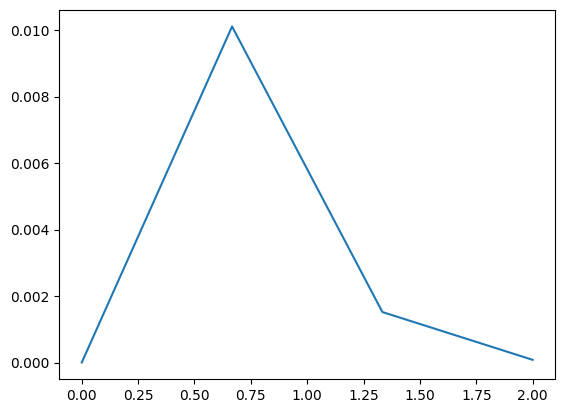

In [91]:
bvp, fs = BVPs[0].signal, 60

peaks = get_peaks(bvp, fs)

if len(peaks) < 4:
    print("Too small:", len(peaks))

rr = np.diff(peaks) / fs
rr_times = np.cumsum(rr)

# Interpolate RR series
rr_interp_time = np.linspace(rr_times[0], rr_times[-1], len(rr))
rr_interp = np.interp(rr_interp_time, rr_times, rr)

freqs, psd = welch(rr_interp, fs=4.0)

plt.plot(freqs, psd)

lf_band = (freqs >= 0.04) & (freqs < 0.15)
hf_band = (freqs >= 0.15) & (freqs < 0.4)

lf = np.trapezoid(psd[lf_band], freqs[lf_band])
hf = np.trapezoid(psd[hf_band], freqs[hf_band])

features = {
    "LF": lf,
    "HF": hf,
    "LF_HF": lf / hf if hf > 0 else 0
}

In [92]:
def morphological_features(bvp, fs):
    peaks = get_peaks(bvp, fs)

    if len(peaks) < 2:
        return None

    amplitudes = bvp[peaks]

    features = {
        "Pulse_amp_mean": np.mean(amplitudes),
        "Pulse_amp_std":  np.std(amplitudes)
    }

    return features


In [93]:
def extract_features_from_bvp(bvp, fs):
    feats = {}

    td = time_domain_features(bvp, fs)
    #fd = frequency_domain_features(bvp, fs)
    md = morphological_features(bvp, fs)

    if td is None or md is None: #or fd is None
        return None

    feats.update(td)
    #feats.update(fd)
    feats.update(md)

    return feats


In [105]:
fs = 60

valid = []

failed = []

failed_masks = [
    [2, "Q1_1"],
    [52, "Q7_2"],
    [53, "Q4_2"]
]

for bvp in BVPs:
    
    feats = extract_features_from_bvp(bvp.signal, fs)

    if feats is None:
        # Do nothing
        print(f"Failed: Patient_{bvp.patient}, {bvp.path}")

        patients.__delitem__(bvp.patient)

        continue
    
    bvp.features = feats

    valid.append(f"Patient_{bvp.patient}, {bvp.path}")

print(f"Extracted features for {len(valid)} videos")


Failed: Patient_14, Q1_2
Extracted features for 238 videos


In [101]:
print(patients)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]


In [98]:
label_map = {
    "Q1": 1,
    "Q2": 1,
    "Q3": 1,
    "Q4": 0,
    "Q5": 0, 
    "Q6": 0,
    "Q7": -1,
    "Q8": -1,
    "Q9": -1
}

def get_label(path):
    q = path.split("_")[0]  # "Q3_2" → "Q3"
    return label_map[q]



In [96]:
for bvp in BVPs:

    try: 

        for feat, val in bvp.features.items():
            print(feat, val)
            i = 1
        #print(bvp.patient, bvp.path, "Success")

    except Exception as e:
        print(bvp.patient, bvp.path, e)


HR_mean 87.44939271255062
HR_std 30.5153998895296
RMSSD 0.24060109910158117
SDNN 0.18140824296950772
pNN50 0.5
Pulse_amp_mean 0.12190616351933667
Pulse_amp_std 0.08709250700561681
HR_mean 74.3801652892562
HR_std 3.3838293736153586
RMSSD 0.06123724356957947
SDNN 0.03590109871423003
pNN50 0.6
Pulse_amp_mean 0.1787408802177131
Pulse_amp_std 0.03086716112526433
HR_mean 119.11764705882354
HR_std 10.685417162358036
RMSSD 0.07046472718869902
SDNN 0.04633331853035853
pNN50 0.5555555555555556
Pulse_amp_mean 0.07637959138470739
Pulse_amp_std 0.13179146469058917
HR_mean 81.81818181818181
HR_std 26.000038236850855
RMSSD 0.17368553960150707
SDNN 0.15184055965240498
pNN50 0.5
Pulse_amp_mean 0.15990807848867664
Pulse_amp_std 0.0866221365878236
HR_mean 85.37549407114624
HR_std 34.76211531521466
RMSSD 0.30605010483034745
SDNN 0.2062488308982952
pNN50 0.5
Pulse_amp_mean 0.2169481782711162
Pulse_amp_std 0.12343462272288878
HR_mean 76.27118644067797
HR_std 10.165067694656663
RMSSD 0.14648663192705785
SDNN

In [ ]:
import numpy as np

X = []
y = []

for bvp in BVPs:
    if bvp is None or bvp.features == []:
        print("Error: Patient", bvp.patient, bvp.path)
        continue

    #print(bvp.patient, bvp.path)
    feat_values = list(bvp.features.values())
    X.append(feat_values)
    y.append(get_label(bvp.path))

X = np.array(X)
y = np.array(y)


Error: Patient 14 Q1_2


AttributeError: 'list' object has no attribute 'delete'

In [106]:
X = []
y = []
patient_ids = []

for bvp in BVPs:
    if bvp is None or not bvp.features:
        continue

    X.append(list(bvp.features.values()))
    y.append(get_label(bvp.path))
    patient_ids.append(bvp.patient)

X = np.array(X)
y = np.array(y)
patient_ids = np.array(patient_ids)


In [108]:
print(X.shape)
print(y.shape)
print(patient_ids.shape)

(238, 7)
(238,)
(238,)


In [ ]:
print(X.shape, y.shape)
print(np.unique(y, return_counts=True))


(235, 7) (235,)
(array([-1,  1]), array([118, 117]))


In [109]:
train_patients = expressive
test_patients  = np.setdiff1d(np.unique(patient_ids), train_patients)

train_idx = np.isin(patient_ids, train_patients)
test_idx  = np.isin(patient_ids, test_patients)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


In [110]:
print(X_train.shape)
print(X_test.shape)

(80, 7)
(158, 7)


LEARNING

In [ ]:
train_patients = expressive   # Expressive Patients
test_patients = np.setdiff1d(patients, train_patients)  # Rest

# train_idx = np.isin(patients, train_patients)
# test_idx  = np.isin(patients, test_patients)

X_train, X_test, y_train, y_test = [], [], [], []

for patient_idx in train_patients:
    X_train.append()

for patient_idx in test_patients:
    X_train.append()

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])



IndexError: boolean index did not match indexed array along axis 0; size of axis is 235 but size of corresponding boolean axis is 59

In [111]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [112]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"  # helpful for imbalance
)

clf.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [113]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [114]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.47      0.47      0.47        80
           1       0.46      0.46      0.46        78

    accuracy                           0.47       158
   macro avg       0.47      0.47      0.47       158
weighted avg       0.47      0.47      0.47       158

[[38 42]
 [42 36]]


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    clf, X, y,
    cv=cv,
    scoring="f1_macro"
)

print("F1 macro:", scores.mean(), "±", scores.std())


F1 macro: 0.49830492651875036 ± 0.10638597759290427


In [ ]:
import pandas as pd

feature_names = list(BVPs[0].features.keys())

importances = clf.feature_importances_
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(imp_df)


          feature  importance
3            SDNN    0.158168
5  Pulse_amp_mean    0.158148
1          HR_std    0.155581
6   Pulse_amp_std    0.149664
2           RMSSD    0.139743
0         HR_mean    0.137542
4           pNN50    0.101154
